# Bibliotheken importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime

c:\Users\kuimi\Documents\Master_Freiberg\Formation_Professionnelle\Data Sciences\Code_Souces\Projets_Portfolio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Daten einlesen und überblick über die Daten

In [2]:
df = pd.read_csv("C:/Users/kuimi/Documents/Master_Freiberg/Formation_Professionnelle/Data Sciences/Code_Souces/Projets_Portfolio/AnalyseSeries_temporelles/btcusd_1-min_data.csv")
df.shape

(7103245, 6)

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103245 entries, 0 to 7103244
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 325.2 MB


,Timestamp,Open,High,Low,Close,Volume
count,7.103245e+06,7.103245e+06,7.103245e+06,7.103245e+06,7.103245e+06,7.103245e+06
mean,1.538511e+09,1.854113e+04,1.854824e+04,1.853381e+04,1.854113e+04,5.242449e+00
std,1.230345e+08,2.587762e+04,2.588548e+04,2.586958e+04,2.587760e+04,2.238067e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.431961e+09,4.300400e+02,4.302500e+02,4.299900e+02,4.300300e+02,1.794857e-02
50%,1.538509e+09,6.760310e+03,6.765000e+03,6.756130e+03,6.760390e+03,4.534117e-01
75%,1.645058e+09,2.841700e+04,2.842532e+04,2.840800e+04,2.841700e+04,2.997560e+00
max,1.751676e+09,1.119930e+05,1.120000e+05,1.119670e+05,1.119750e+05,5.853852e+03


In [4]:
df.isnull().sum()

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [5]:
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Timestamp'])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [7]:
# 🧹 Vorverarbeitung
df = df[['Volume']].copy()
df = df.dropna()

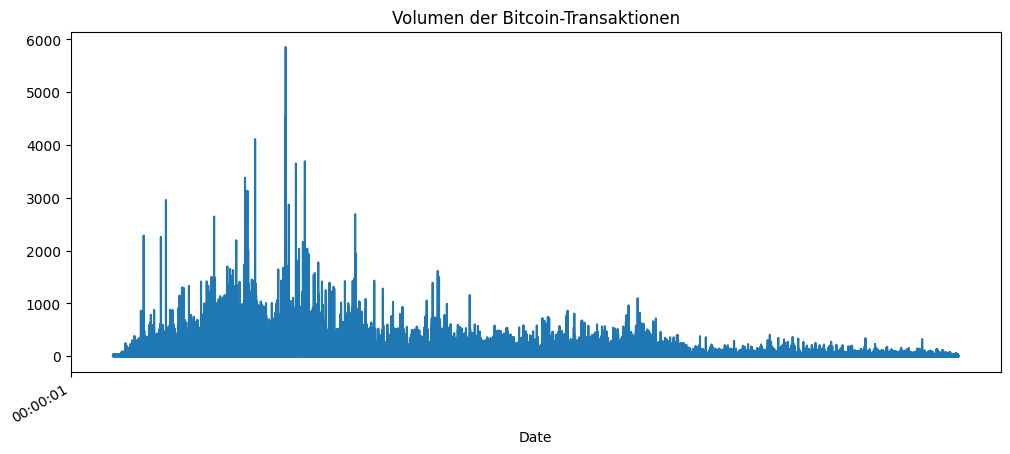

In [8]:
# 📊 Visualisierung der Zeitreihe
plt.figure(figsize=(12, 5))
df['Volume'].plot(title="Volumen der Bitcoin-Transaktionen")
plt.show()

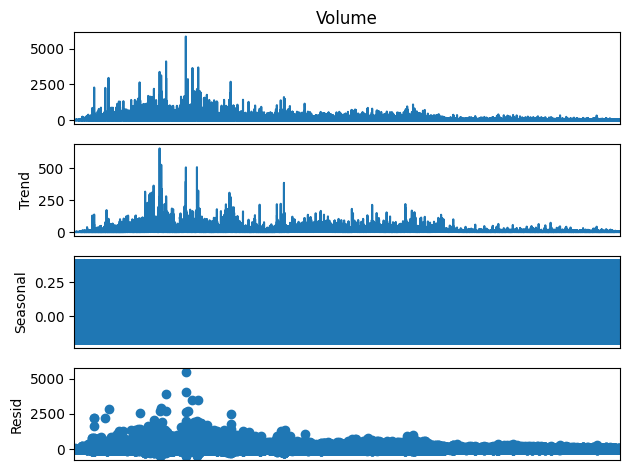

In [9]:
# 📉 Saisonale Zerlegung
result = seasonal_decompose(df['Volume'], model='additive', period=30)
result.plot()
plt.show()

In [10]:
# 🔮 Modèle SARIMA sur un sous-échantillon
# Nimm die letzten 10.000 Zeilen als Stichprobe
df_sample = df.tail(10000)
model = SARIMAX(df_sample['Volume'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
pred_sarima = results.forecast(steps=30)

c:\Users\kuimi\Documents\Master_Freiberg\Formation_Professionnelle\Data Sciences\Code_Souces\Projets_Portfolio\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 60ns will be used.
  self._init_dates(dates, freq)
c:\Users\kuimi\Documents\Master_Freiberg\Formation_Professionnelle\Data Sciences\Code_Souces\Projets_Portfolio\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 60ns will be used.
  self._init_dates(dates, freq)


In [11]:
# 📈 Modèle Prophet
# Utiliser seulement les 10 000 dernières lignes
prophet_df = df.tail(10000).reset_index().rename(columns={"Date": "ds", "Volume": "y"})
model_prophet = Prophet()
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

07:29:34 - cmdstanpy - INFO - Chain [1] start processing
07:29:35 - cmdstanpy - INFO - Chain [1] done processing


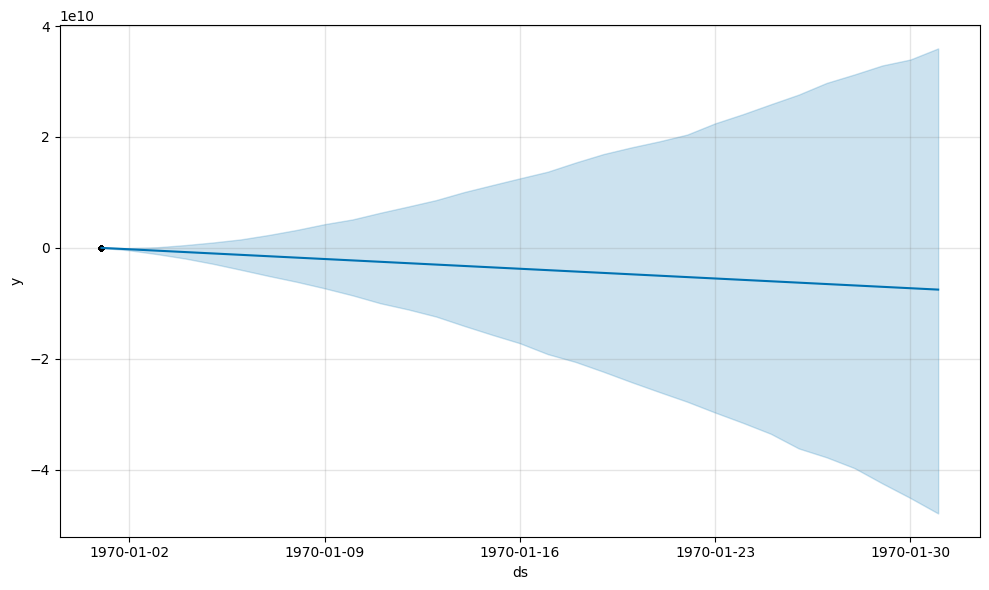

In [12]:
# 📊 Visualisierung der Prophet-Vorhersagen
model_prophet.plot(forecast)
plt.show()

In [13]:
# 🌲 XGBoost-Modell
# Erstellung der zeitlichen Features
df_xgb = df.copy()
df_xgb['day'] = df_xgb.index.day
df_xgb['month'] = df_xgb.index.month
df_xgb['year'] = df_xgb.index.year
df_xgb['dayofweek'] = df_xgb.index.dayofweek
df_xgb['lag1'] = df_xgb['Volume'].shift(1)
df_xgb = df_xgb.dropna()

X = df_xgb.drop('Volume', axis=1)
y = df_xgb['Volume']

X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)

In [14]:
# 📏 Bewertung
print("MAE SARIMA:", mean_absolute_error(y_test, pred_sarima))
print("MAE XGBoost:", mean_absolute_error(y_test, pred_xgb))

MAE SARIMA: 0.10173810686406264
MAE XGBoost: 1.205549649860306


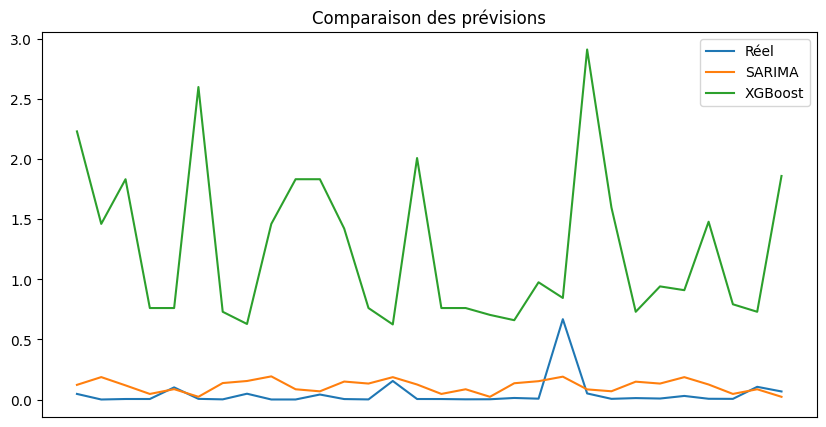

In [15]:
# 📈 Grafischer Vergleich
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Réel")
plt.plot(y_test.index, pred_sarima, label="SARIMA")
plt.plot(y_test.index, pred_xgb, label="XGBoost")
plt.legend()
plt.title("Comparaison des prévisions")
plt.show()